# Trainable Distributions

> In this post, we will take a look at how to make the parameters of distribution object trainable. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/tfd_trainable_distribution.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

Previously, we just define the mean and standard deviation with floating type, but we can also use optimizer object to apply gradients obtained from a loss function and data.

In [3]:
normal = tfd.Normal(loc=tf.Variable(0., name='loc'), scale=1.)

In [4]:
normal.trainable_variables

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=0.0>,)

Now it has trainable variables. And this distribution is now trainable distribution.

For example, we can use it like this, (for the case of negative log likelihood)

In [5]:
def nll(X_train):
    return -tf.reduce_mean(normal.log_prob(X_train))

This function may return the tensor which have same shape of `X_train`. If we can assume that the training data is under IID (Independently and Indentically distributed) assumption, then the log probability of our data will be the sum of log probability of each data point.

In the training loop,

In [ ]:
@tf.function
def get_loss_and_grads(X_train):
    with tf.GradientTape() as tape:
        tape.watch(normal.trainable_variables)
        loss = nll(X_train)
    grads = tape.gradient(loss, normal.trainable_variables)
    return loss, grads

Note that, we can speed up the computation of gradient with python decorator `@tf.function`. And it makes a computation graph out of the function.

After that, we can make a loop for training.

```python
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

for _ in range(num_steps):
    loss, grads = get_loss_and_grads(X_sample)
    optimizer.apply_gradients(zip(grads, normal.trainable_variables))
```

## Tutorial

In [6]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

In [7]:
# Define an exponential distribution
exponential = tfd.Exponential(rate=0.3, name='exp')

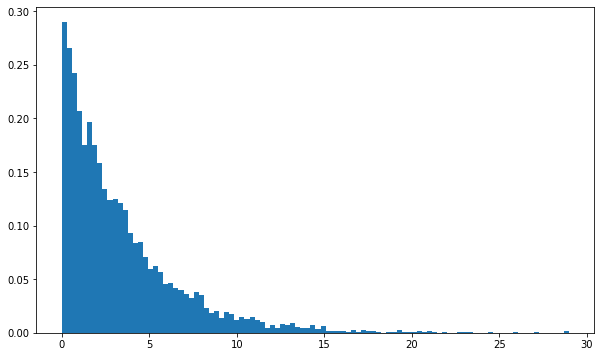

In [9]:
# Plot
plt.hist(exponential.sample(5000).numpy(), bins=100, density=True)
plt.show()

In [10]:
# Define an exponential distribution with a trainable rate parameter
exponential_train = tfd.Exponential(rate=tf.Variable(1., name='rate'), name='exp_train')
exponential_train.trainable_variables

(<tf.Variable 'rate:0' shape=() dtype=float32, numpy=1.0>,)

In [11]:
# Define a negative log likelihood
def nll(X_train, distribution):
    return -tf.reduce_mean(distribution.log_prob(X_train))

In [15]:
# Define a function to compute loss and gradients
@tf.function
def get_loss_and_grads(X_train, distribution):
    with tf.GradientTape() as tape:
        tape.watch(distribution.trainable_variables)
        loss = nll(X_train, distribution)
    grads = tape.gradient(loss, distribution.trainable_variables)
    return loss, grads

In [20]:
# Optimize
def exponential_dist_optimization(data, distribution):
    # Keep results for plotting
    train_loss_results = []
    train_rate_results = []
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
    
    num_steps = 10
    
    for i in range(num_steps):
        loss, grads = get_loss_and_grads(data, distribution)
        optimizer.apply_gradients(zip(grads, distribution.trainable_variables))
        
        rate_value = distribution.rate.value()
        train_loss_results.append(loss)
        train_rate_results.append(rate_value)
        
        print("Step {:03d}: Loss: {:.3f}: Rate: {:.3f}".format(i, loss, rate_value))
        
    return train_loss_results, train_rate_results

In [21]:
# Get some data and train
sampled_data  = exponential.sample(5000)
train_loss_results, train_rate_results = exponential_dist_optimization(data=sampled_data, distribution=exponential_train)

Step 000: Loss: 2.896: Rate: 0.669
Step 001: Loss: 2.682: Rate: 0.573
Step 002: Loss: 2.510: Rate: 0.490
Step 003: Loss: 2.383: Rate: 0.422
Step 004: Loss: 2.301: Rate: 0.370
Step 005: Loss: 2.255: Rate: 0.335
Step 006: Loss: 2.235: Rate: 0.314
Step 007: Loss: 2.228: Rate: 0.303
Step 008: Loss: 2.227: Rate: 0.297
Step 009: Loss: 2.226: Rate: 0.295


In [22]:
# Predicted value for the rate parameter

pred_value = exponential_train.rate.numpy()
exact_value = exponential.rate.numpy()

print("Exact rate: ", exact_value)
print("Predicted rate: ", pred_value)

Exact rate:  0.3
Predicted rate:  0.29511935


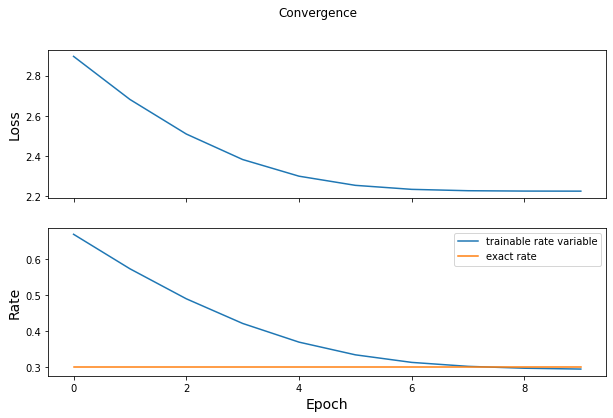

In [23]:
# Plot to see the convergence of the estimated and true parameters
tensor_exact_value = tf.constant(exact_value, shape=[len(train_rate_results)])

fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Convergence')

ax[0].set_ylabel('Loss', fontsize=14)
ax[0].plot(train_loss_results)

ax[1].set_ylabel('Rate', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].plot(train_rate_results, label='trainable rate variable')
ax[1].plot(tensor_exact_value, label='exact rate')
ax[1].legend()

plt.show()

In [32]:
# Making a function get_data which:
#   1) Fetches the 20 newsgroup dataset
#   2) Performs a word count on the articles and binarizes the result
#   3) Returns the data as a numpy matrix with the labels

def get_data(categories):

    newsgroups_train_data = fetch_20newsgroups(data_home='./dataset/20_Newsgroup_Data/',
                                               subset='train', categories=categories)
    newsgroups_test_data = fetch_20newsgroups(data_home='./dataset/20_Newsgroup_Data/',
                                              subset='test', categories=categories)

    n_documents = len(newsgroups_train_data['data'])
    count_vectorizer = CountVectorizer(input='content', binary=True,max_df=0.25, min_df=1.01/n_documents) 
    train_binary_bag_of_words = count_vectorizer.fit_transform(newsgroups_train_data['data']) 
    test_binary_bag_of_words = count_vectorizer.transform(newsgroups_test_data['data']) 

    return (train_binary_bag_of_words.todense(), newsgroups_train_data['target']),  (test_binary_bag_of_words.todense(), newsgroups_test_data['target'])

In [33]:
# Defining a function to conduct laplace smoothing. This adds a base level of probability for a given feature
# to occur in every class.

def laplace_smoothing(labels, binary_data, n_classes):
    # Compute the parameter estimates (adjusted fraction of documents in class that contain word)
    n_words = binary_data.shape[1]
    alpha = 1 # parameters for Laplace smoothing
    theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
    for c_k in range(n_classes): # 0, 1, ..., 19
        class_mask = (labels == c_k)
        N = class_mask.sum() # number of articles in class
        theta[c_k, :] = (binary_data[class_mask, :].sum(axis=0) + alpha)/(N + alpha*2)

    return theta

In [34]:
# Now we will do a function that given the feature occurence counts returns a Bernoulli distribution of 
# batch_shape=number of classes and event_shape=number of features.

def make_distributions(probs):
    batch_of_bernoullis = tfd.Bernoulli(probs=probs) # shape (n_classes, n_words)
    dist = tfd.Independent(batch_of_bernoullis, reinterpreted_batch_ndims=1)
    return dist

In [35]:
# Function which computes the prior probability of every class based on frequency of occurence in 
# the dataset

def class_priors(n_classes, labels):
    counts = np.zeros(n_classes)
    for c_k in range(n_classes):
        counts[c_k] = np.sum(np.where(labels==c_k, 1, 0))
    priors = counts / np.sum(counts)
    print('The class priors are {}'.format(priors))
    return priors

In [36]:
# The final function predict_sample which given the distribution, a test sample, and the class priors:
#   1) Computes the class conditional probabilities given the sample
#   2) Forms the joint likelihood
#   3) Normalises the joint likelihood and returns the log prob

def predict_sample(dist, sample, priors):
    cond_probs = dist.log_prob(sample)
    joint_likelihood = tf.add(np.log(priors), cond_probs)
    norm_factor = tf.math.reduce_logsumexp(joint_likelihood, axis=-1, keepdims=True)
    log_prob = joint_likelihood - norm_factor

    return log_prob

In [37]:
# Now we learn the distribution using gradient tape

def make_distribution_withGT(data, labels, nb_classes):

    class_data = []
    train_vars = []
    distributions = []
    for c in range(nb_classes):
        train_vars.append(tf.Variable(initial_value=np.random.uniform(low=0.01, high =0.1, size=data.shape[-1])))
        distributions.append(tfd.Bernoulli(probs=train_vars[c]))
        class_mask = (labels == c)
        class_data.append(data[class_mask, :])

    for c_num in range(0,nb_classes):
        optimizer = tf.keras.optimizers.Adam()
        print('\n%-------------------%')
        print('Class ', c_num)
        print('%-------------------%')

        for i in range(0, 100):
            loss, grads = get_loss_and_grads(class_data[c_num], distributions[c_num])
            if i % 10 == 0:
                print("iter: {}, Loss: {}".format(i, loss))
            optimizer.apply_gradients(zip(grads, distributions[c_num].trainable_variables))
            eta = 1e-3
            clipped_probs = tf.clip_by_value(distributions[c_num].trainable_variables,
                                             clip_value_min=eta, clip_value_max=1)
            
            train_vars[c_num] = tf.squeeze(clipped_probs)

    dist = tfd.Bernoulli(probs=train_vars)
    dist = tfd.Independent(dist,reinterpreted_batch_ndims=1)

    print(dist)

    return dist


In [38]:
# Make the same Naive Bayes classifier we did last tutorial

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

(train_data, train_labels), (test_data, test_labels) = get_data(categories)

smoothed_counts = laplace_smoothing(labels=train_labels, binary_data=train_data, n_classes=len(categories))

priors = class_priors(n_classes=len(categories), labels=train_labels)
tf_dist = make_distributions(smoothed_counts)

The class priors are [0.2359882  0.28711898 0.29154376 0.18534907]


In [39]:
# Now train the distributions with gradient tape
GT_dist = make_distribution_withGT(data=train_data, labels=train_labels, nb_classes=4)


%-------------------%
Class  0
%-------------------%
iter: 0, Loss: 0.07864662925861293
iter: 10, Loss: 0.06923920529302693
iter: 20, Loss: 0.060484430932711934
iter: 30, Loss: 0.052378958091660745
iter: 40, Loss: 0.044884874447401975
iter: 50, Loss: 0.03795957675935009
iter: 60, Loss: 0.03156166893228506
iter: 70, Loss: 0.025648909539426928
iter: 80, Loss: 0.020179556307287093
iter: 90, Loss: 0.015095419046706705

%-------------------%
Class  1
%-------------------%
iter: 0, Loss: 0.07162433404608501
iter: 10, Loss: 0.06226791554203955
iter: 20, Loss: 0.053458417310592254
iter: 30, Loss: 0.04525733720016119
iter: 40, Loss: 0.03764243521857365
iter: 50, Loss: 0.0305879746963904
iter: 60, Loss: 0.02407123784997883
iter: 70, Loss: 0.018063326103411242
iter: 80, Loss: 0.012530662501078415
iter: 90, Loss: 0.007417711392007358

%-------------------%
Class  2
%-------------------%
iter: 0, Loss: 0.07864916432960509
iter: 10, Loss: 0.06954586738662134
iter: 20, Loss: 0.061138999776087846
ite

In [40]:
# Compare the two results

for dist in [GT_dist,tf_dist]:
    probabilities = []
    for sample, label in zip(test_data, test_labels):
        probabilities.append(predict_sample(dist, sample, priors))

    probabilities = np.asarray(probabilities)
    predicted_classes = np.argmax(probabilities, axis =-1)
    print('f1 ', f1_score(test_labels, predicted_classes, average='macro'))

f1  0.8265056782070946
f1  0.7848499112849504
